In [493]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#指定默认字体
# matplotlib.rcParams['font.sans-serif'] = ['SimHei']
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft Yahei']
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False

mu = np.arange(0.1, 0.81, 0.1)
learn = np.arange(0.2, 1.01, 0.2)
radius = np.arange(3, 11.1, 2)
sense = np.arange(0.2, 1.01, 0.2)
year = np.arange(2006,2017,1)
print(mu)
print(learn)
print(radius)
print(sense)
print(year)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[0.2 0.4 0.6 0.8 1. ]
[ 3.  5.  7.  9. 11.]
[0.2 0.4 0.6 0.8 1. ]
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]


In [494]:
simulation = pd.read_csv(open(r'../data/abm_farmer/simulations.csv'))
sim = simulation[['id','mu','learn','sense','radius']]
country = pd.read_csv(r'../data/abm_farmer/country_traces.csv')
# farmerInit = pd.read_csv(open(r'../data/abm_farmer/farmer_inits.csv'))
# farmerAnchor = pd.read_csv(r'../data/abm_farmer/farmer_anchors.csv')
country['time'] = country['time'].apply(lambda x: x.split('-')[0])

## 0.  连表筛选数据

In [495]:
def getSimId(mu, learn, sense, radius):
    temp = sim[(sim['mu']==mu) & (sim['learn']==learn) & (sim['sense']==sense) & (sim['radius']==radius)]
    return temp['id'].values[0]
# sim = simulation[['id','mu','learn','sense','radius']][(simulation['mu']==0.3) & (simulation['learn']==0.2) & (simulation['sense']==0.2) & (simulation['radius']==3)]
# print(sim['id'].values[0])
# print(sim.loc[0:3,'id']) #基于标签      iloc[0:1, 2:5] 完全是基于索引
# print(getSimId(0.3,0.2,0.2,5))

def getCountryData(simId, sortedBy):
    temp = country[country['sim_id'] == simId].sort_values(by=sortedBy)
    return temp
# temp = country[country['sim_id'] == getSimId(0.3,0.2,0.2,3)].sort_values(by='time')
# print(temp)
# print(getCountryData(getSimId(0.3,0.2,0.2,5), 'time'))

## 1. 基准模型

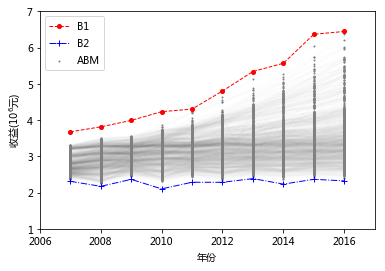

In [619]:
year = np.arange(2007,2017,1)

plotX = []
plotY = []
plotMaxY = []
plotMinY = []

for y in year:
    strY = str(y)
    tempY = country[country['time']==strY]['crop_income'].values
    tempX = [y] * len(tempY)
    plotX.append(tempX)
    plotY.append(tempY)
    plotMaxY.append(tempY.max())
    plotMinY.append(tempY.min())
    
scale = 1.0 * 1e6


plotY = np.array(plotY) / scale
np.random.seed(666)
plotB1Y = np.array(plotMaxY) / scale + np.random.normal(0.0,0.2, size=len(plotMaxY)) + 0.2
np.random.seed(20)
plotB2Y = np.array(plotMinY) / scale + np.random.normal(0.0,0.05, size=len(plotMaxY)) - 0.1

plt.scatter(plotX, plotY, s=1, c='grey', label='ABM')
plt.plot(plotX, plotY, linewidth=2.0, color='grey', alpha=0.01)

plt.plot(year, plotB1Y, 'ro--', linewidth=1, markersize=4, label='B1')
plt.plot(year, plotB2Y, 'b+-.', linewidth=1, markersize=6, label='B2')


plt.ylabel(r'收益($10^6$元)')
plt.xlabel(r'年份')
plt.legend()
plt.axis([2006, 2017, 1, 7])

plt.show()

## 2. 旱地占比与灌溉量分析及校验

In [500]:
def filterCountry(filters, replaceSimIdBy):
    '''
        function : filter country table with filters, replace the field 'sim_id' with replaceSimIdBy
        filters : dictionnary, key must equal with the country and sim field
        repalceSimIdBy : the new DataFrame sim_id => filterValue
        example:
            mu = [0.3,0.4,...]
            >> temp = filterCountry({'learn':0.6, 'radius':7., 'sense':0.6}, 'mu')
            >> print(temp)
            id  sim_id  time  precipitation  crop_irrigation  rice_irrigation  \
    3962  3963     0.3  2006         398.50        299911.95        270254.82   
    3966  3967     0.3  2007         455.70        462937.64        395925.46   
    3970  3971     0.3  2008         475.98        328978.88        290908.39   
    3974  3975     0.3  2009         265.96        469009.19        401609.49 
    '''
    keys = filters.keys()
    values = filters.values()
    condition = 1
    for key, value in zip(keys, values):
        condition = condition & (abs(sim[key]-value) < 0.01)
    simMu = sim[condition]
    simIds = simMu['id'].values
    countryMu = country[country['sim_id'].isin(simIds)]
    countryMu['sim_id'] = countryMu['sim_id'].apply(lambda x: simMu[simMu['id']==x][replaceSimIdBy].values[0])
    return countryMu

# condition = (abs(sim['learn']-0.6) < 0.01) & (abs(sim['radius']-7.) < 0.01) & (abs(sim['sense']-0.6) < 0.01)
# simMu = sim[condition]
# simIds = simMu['id'].values
# countryMu = country[country['sim_id'].isin(simIds)]
# countryMu['sim_id'] = countryMu['sim_id'].apply(lambda x: simMu[sim['id']==x]['mu'].values[0])
# print(countryMu, countryMu.columns)
# temp = filterCountry({'learn':0.6, 'radius':7., 'sense':0.6}, 'mu')

# m1 = temp[abs(temp['sim_id'] - 0.3) < 0.01]
# m2 = temp[abs(temp['sim_id'] - 0.5) < 0.01]
# m3 = temp[abs(temp['sim_id'] - 0.7) < 0.01]

# tempX = tempMu['time'].values
# plt.plot(tempX, m1['crop_income'].values, 'ro--', label=r'$\mu$ = ' + str(0.3))
# plt.plot(tempX, m2['crop_income'].values, 'g+-.', label=r'$\mu$ = ' + str(0.5))
# plt.plot(tempX, m3['crop_income'].values, 'bo:', label=r'$\mu$ = ' + str(0.7))
# plt.legend()
# plt.show()

# temp = filterCountry({'learn':0.6, 'radius':7, 'sense':0.6}, 'mu')
# muList = [0.3, 0.5, 0.7]
# style = ['r^-','g+-','bo-']
# showMu(plt, temp, muList, style) 


def showParam(ax, filters, paraName = 'mu', paraList = [0.3, 0.5, 0.7], style = ['r^-','g+-','bo-']):
    data = filterCountry(filters, paraName)
    
    scale = 1.0 * 1e6
    ax.set(xlabel='年份', ylabel=r'收益($10^6$元)')
    halfLabel = r'$\mu$ = '
    
    for m,s in zip(paraList, style):
        muData = data[abs(data['sim_id'] - m) < 0.001]
        tempX = muData['time'].values
        tempY = muData['crop_income'].values / scale
        ax.plot(tempX, tempY, s, label=halfLabel + str(m))
        
        
def showParam(ax, filters, paraName = 'sense', paraLabel = None, paraList = [0.2, 0.6, 1.0], style = ['r^-','g+-','bo-']):
    data = filterCountry(filters, paraName)   
    scale = 1.0 * 1e6
    ax.set(xlabel='年 份', ylabel=r'收益($10^6$元)')
    for m,s in zip(paraList, style):
        muData = data[abs(data['sim_id'] - m) < 0.001]
        tempX = muData['time'].values
        tempY = muData['crop_income'].values / scale
        ax.plot(tempX, tempY, s, linewidth=1.6, markersize=4, label= paraLabel + ' = ' + str(m))


# showParam(plt, filters = {'learn':0.6, 'radius':7, 'sense':0.6}, paraName = 'mu', paraList = [0.3, 0.5, 0.7], style = ['r^-','g+-','bo-'])
# plt.legend()
# plt.show()
# print(learn, radius, sense)

### 2.1 subplots初探

In [501]:
# 刻度设置
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def setTicks(ax):
    xMajorLocator   = MultipleLocator(2) #将x主刻度标签设置为2的倍数
    xMinorLocator   = MultipleLocator(1) #将x轴次刻度标签设置为1的倍数
    xMajorFormatter = FormatStrFormatter('%d') #设置x轴标签文本的格式
    ax.xaxis.set_major_locator(xMajorLocator)
    ax.xaxis.set_major_formatter(xMajorFormatter)
    ax.xaxis.set_minor_locator(xMinorLocator)
    ax.set_xticklabels(np.arange(2004,2017,2)) # 要将所显示的刻度包在其中
    
#     yMajorLocator   = MultipleLocator(5000000) 
#     yMinorLocator   = MultipleLocator(2500000) 
#     yMajorFormatter = FormatStrFormatter('%8.1f')
#     ax.yaxis.set_major_locator(yMajorLocator)
#     ax.yaxis.set_major_formatter(yMajorFormatter)
#     ax.yaxis.set_minor_locator(yMinorLocator)

#             axes[axNum].axis([2006, 2017, 1800000, 4500000])
#             axes[axNum].set_xlim(2005, 2016)
#             axes[axNum].set_ylim(1800000, 4500000)
#             axes[axNum].set_xticks(np.arange(2005,2016,2))
#     ax.set_xticklabels(np.arange(2005,2016.01,2))

### 2.2 mu分析

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


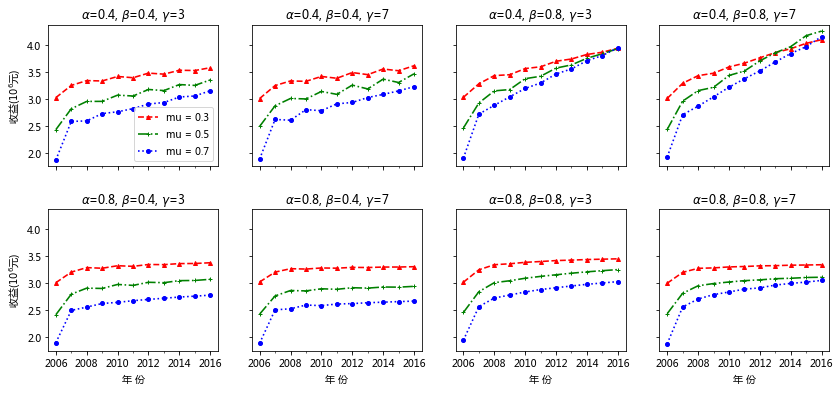

In [631]:
# Simple data to display in various forms
se = [0.4, 0.8]
le = [0.4, 0.8]
ra = [3, 7]
plt.close('all')
# f, axarr = plt.subplots(2, 4, figsize=[12, 6])
f, axarr = plt.subplots(2, 4, figsize=[14, 6], sharex=True, sharey=True)
# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.3)

axes = axarr.flat
axNum = 0
for s in se:
    for l in le:
        for r in ra:
            filters = {'sense':s, 'learn':l, 'radius':r}
            showParam(axes[axNum], filters = filters, paraName = 'mu', paraLabel = 'mu', paraList = [0.3, 0.5, 0.7], style = ['r^--','g+-.','bo:'])
            axes[axNum].set_title(r'$\alpha$=' + str(s) + r', $\beta$='+ str(l) + r', $\gamma$=' + str(r))
            setTicks(axes[axNum])
            axNum += 1
            
axarr[0, 0].legend(loc='best')
# for ax in axarr.flat:
#     ax.set(xlabel='年份', ylabel='收益')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()
    
plt.show()

### 2.3 根据alpha的不同将主体分为 敏感性主体(alpha=0.4), 和迟钝型主体(alpha=0.8), 观察其耕种结构变化以及用水量

In [503]:
def countryData(filters):
    keys = filters.keys()
    values = filters.values()
    condition = 1
    for key, value in zip(keys, values):
        condition = condition & (abs(sim[key]-value) < 0.01)
    tempSim = sim[condition]
    simIds = tempSim['id'].values
    tempCountry = country[country['sim_id'].isin(simIds)]
    return tempCountry

In [504]:
# senseAgent = countryData({'mu'=0.5, 'sense':0.4, 'learn':0.8, 'radius':9})
senseAgent = filterCountry({'mu':0.5, 'sense':0.4, 'learn':0.8, 'radius':7}, 'sense')
slowAgent = filterCountry({'mu':0.5, 'sense':0.8, 'learn':0.8, 'radius':7}, 'sense')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


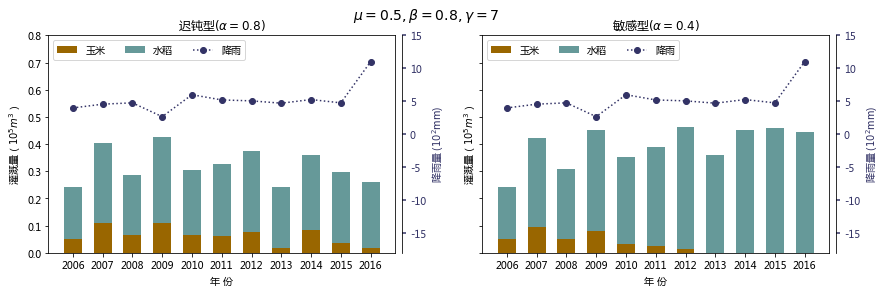

In [637]:
plt.close('all')
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
def showIrriation(hostAx, data):
    scale12 = 1. * 1e5
    tempX = data['time'].values
    tempY1 = data['maize_irrigation'].values / scale
    tempY2 = data['rice_irrigation'].values / scale
    p1 = hostAx.bar(tempX, tempY1, width=0.6, color='#996600')
    p2 = hostAx.bar(tempX, tempY2, bottom=tempY1, width=0.6, color='#669999')
    hostAx.set_xlabel(u"年 份")
    hostAx.set_ylabel(u"灌溉量（$10^5m^3$）")
    hostAx.set_ylim(0,0.8)
       
    parasiteAx = hostAx.twinx()
    # Offset the right spine of parasiteAx. The ticks and label have already been placed on the right by twinx above.
    parasiteAx.spines["right"].set_position(("axes", 1.02))
    # First, activate the frame but make the patch and spines invisible.
    make_patch_spines_invisible(parasiteAx)
    # Second, show the right spine(spine 边界的轴线，ticks位于轴线上).
    parasiteAx.spines["right"].set_visible(True)
    scale3 = 1. * 1e2
    tempY3 = data['precipitation'].values / scale3
    p3, = parasiteAx.plot(tempX, tempY3, color='#333366', marker='o', linestyle=':')
    parasiteAx.set_ylabel(u"降雨量 ($10^2$mm)")
    parasiteAx.set_ylim(-18,15)
    # 设置刻度属性：刻度长短粗细，根据p3的值设置刻度颜色，标签颜色
    tkw = dict(size=4, width=1.5)
    parasiteAx.tick_params(axis='y', colors=p3.get_color(), **tkw)
    parasiteAx.yaxis.label.set_color(p3.get_color())
    
    hostAx.legend((p1[0], p2[0], p3), (u"玉米", u"水稻", u"降雨"), loc='upper left', ncol=3)


fig, hostArr = plt.subplots(1, 2, figsize=[14, 4], sharey=True)
fig.suptitle(r'$\mu=0.5,\beta=0.8,\gamma=7$', fontsize=14)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)

showIrriation(hostArr[0], slowAgent)
hostArr[0].set_title(r'迟钝型$(\alpha=0.8)$')
showIrriation(hostArr[1], senseAgent)
hostArr[1].set_title(r'敏感型$(\alpha=0.4)$')
plt.show()

## 3. 单一行为因素分析

#### 3.1 alpha: sense敏感因素分析

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


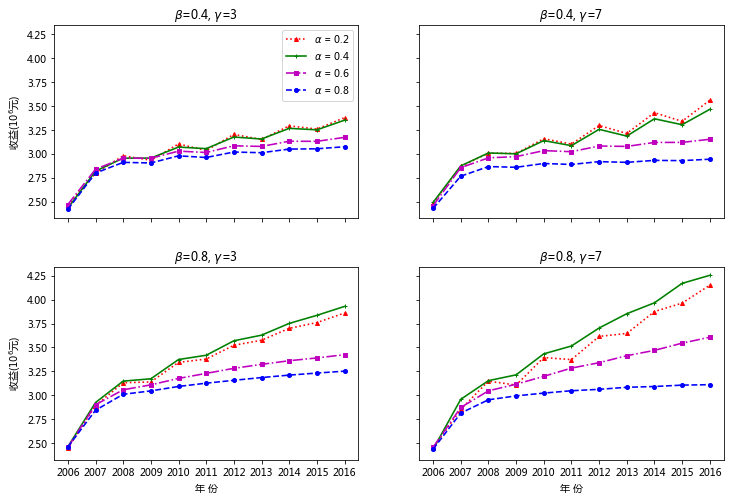

In [509]:
def filterCountry(filters, replaceSimIdBy):
    keys = filters.keys()
    values = filters.values()
    condition = 1
    for key, value in zip(keys, values):
        condition = condition & (abs(sim[key]-value) < 0.01)
    simMu = sim[condition]
    simIds = simMu['id'].values
    countryMu = country[country['sim_id'].isin(simIds)]
    countryMu['sim_id'] = countryMu['sim_id'].apply(lambda x: simMu[simMu['id']==x][replaceSimIdBy].values[0])
    return countryMu

def showParam(ax, filters, paraName = 'sense', paraLabel = None, paraList = [0.2, 0.6, 1.0], style = ['r^-','g+-','bo-']):
    data = filterCountry(filters, paraName)   
    scale = 1.0 * 1e6
    ax.set(xlabel='年 份', ylabel=r'收益($10^6$元)')
    for m,s in zip(paraList, style):
        muData = data[abs(data['sim_id'] - m) < 0.001]
        tempX = muData['time'].values
        tempY = muData['crop_income'].values / scale
        ax.plot(tempX, tempY, s, linewidth=1.6, markersize=4, label= paraLabel + ' = ' + str(m))


plt.close('all')
# Simple data to display in various forms
le = [0.4, 0.8]
ra = [3, 9]
f, axarr = plt.subplots(2, 2, figsize=[12, 8], sharex=True, sharey=True)
f.subplots_adjust(hspace=0.25)

axFlat = axarr.flat
axNum = 0
for l in le:
    for r in ra:
        filters = {'mu':0.5, 'learn':l, 'radius':r}
        showParam(axFlat[axNum], filters = filters, paraName = 'sense', paraLabel = r'$\alpha$', paraList = [0.2, 0.4, 0.6, 0.8], style = ['r^:','g+-', 'ms-.', 'bo--'])
        axFlat[axNum].set_title(r'$\beta$='+ str(l) + r', $\gamma$=' + str(r))
#         setTicks(axFlat[axNum])
        axNum += 1
            
axarr[0, 0].legend(loc='best')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()
    
plt.show()

#### 3.2 beta: learn学习因素分析

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


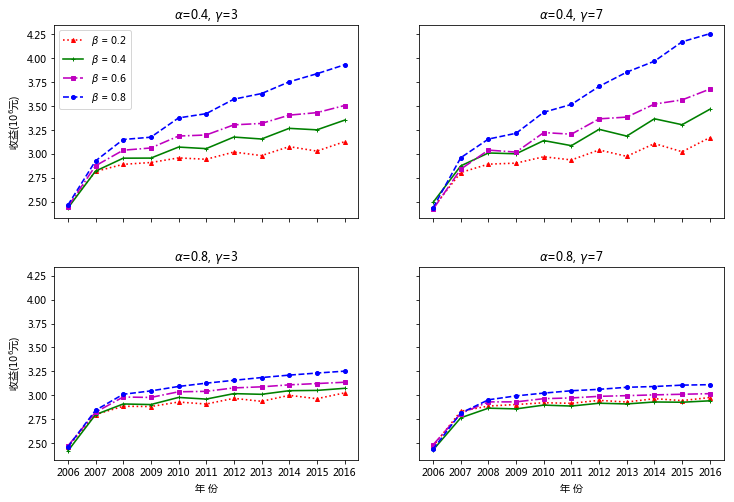

In [510]:
def filterCountry(filters, replaceSimIdBy):
    keys = filters.keys()
    values = filters.values()
    condition = 1
    for key, value in zip(keys, values):
        condition = condition & (abs(sim[key]-value) < 0.01)
    simMu = sim[condition]
    simIds = simMu['id'].values
    countryMu = country[country['sim_id'].isin(simIds)]
    countryMu['sim_id'] = countryMu['sim_id'].apply(lambda x: simMu[simMu['id']==x][replaceSimIdBy].values[0])
    return countryMu

def showParam(ax, filters, paraName, paraLabel, paraList, style):
    data = filterCountry(filters, paraName)   
    scale = 1.0 * 1e6
    ax.set(xlabel='年 份', ylabel=r'收益($10^6$元)')
    for m,s in zip(paraList, style):
        muData = data[abs(data['sim_id'] - m) < 0.001]
        tempX = muData['time'].values
        tempY = muData['crop_income'].values / scale
        ax.plot(tempX, tempY, s, linewidth=1.6, markersize=4, label= paraLabel + ' = ' + str(m))


plt.close('all')
# Simple data to display in various forms
m = 0.5
se = [0.4, 0.8]
ra = [3, 7]

paraName = 'learn'
paraLabel = r'$\beta$'
paraList = [0.2,0.4,0.6,0.8]
style = ['r^:','g+-', 'ms-.', 'bo--']

f, axarr = plt.subplots(2, 2, figsize=[12, 8], sharex=True, sharey=True)
f.subplots_adjust(hspace=0.25)

axFlat = axarr.flat
axNum = 0
for s in se:
    for r in ra:
        filters = {'mu':m, 'sense':s, 'radius':r}
        showParam(axFlat[axNum], filters=filters, paraName=paraName, paraLabel=paraLabel, paraList=paraList, style=style)
        axFlat[axNum].set_title(r'$\alpha$='+ str(s) + r', $\gamma$=' + str(r))
#         setTicks(axFlat[axNum])
        axNum += 1
            
axarr[0, 0].legend(loc='best')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()
    
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


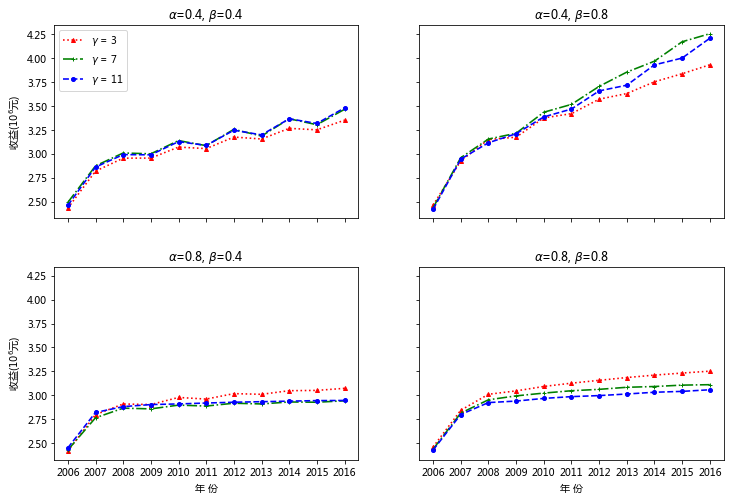

In [511]:
def filterCountry(filters, replaceSimIdBy):
    keys = filters.keys()
    values = filters.values()
    condition = 1
    for key, value in zip(keys, values):
        condition = condition & (abs(sim[key]-value) < 0.01)
    simMu = sim[condition]
    simIds = simMu['id'].values
    countryMu = country[country['sim_id'].isin(simIds)]
    countryMu['sim_id'] = countryMu['sim_id'].apply(lambda x: simMu[simMu['id']==x][replaceSimIdBy].values[0])
    return countryMu

def showParam(ax, filters, paraName, paraLabel, paraList, style):
    data = filterCountry(filters, paraName)   
    scale = 1.0 * 1e6
    ax.set(xlabel='年 份', ylabel=r'收益($10^6$元)')
    for m,s in zip(paraList, style):
        muData = data[abs(data['sim_id'] - m) < 0.001]
        tempX = muData['time'].values
        tempY = muData['crop_income'].values / scale
        ax.plot(tempX, tempY, s, linewidth=1.6, markersize=4, label= paraLabel + ' = ' + str(m))


plt.close('all')
# Simple data to display in various forms
m = 0.5
se = [0.4, 0.8]
le = [0.4, 0.8]


paraName = 'radius'
paraLabel = r'$\gamma$'
paraList = [3,7,11]
style = ['r^:','g+-.','bo--']

f, axarr = plt.subplots(2, 2, figsize=[12, 8], sharex=True, sharey=True)
f.subplots_adjust(hspace=0.25)

axFlat = axarr.flat
axNum = 0
for s in se:
    for l in le:
        filters = {'mu':m, 'sense':s, 'learn':l}
        showParam(axFlat[axNum], filters=filters, paraName=paraName, paraLabel=paraLabel, paraList=paraList, style=style)
        axFlat[axNum].set_title(r'$\alpha$='+ str(s) + r', $\beta$=' + str(l))
#         setTicks(axFlat[axNum])
        axNum += 1
            
axarr[0, 0].legend(loc='upper left')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()
    
plt.show()

## 3 多因素组合分析

[3 4 5 6 7 3 4 5 6 7 3 4 5 6 7 3 4 5 6 7 3 4 5 6 7]
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4]


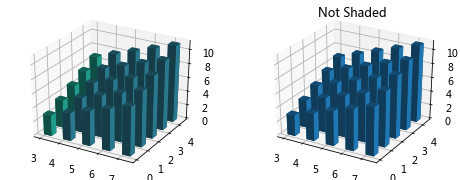

In [512]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


# setup the figure and axes
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# fake data
_x = np.arange(3,8,1)
_y = np.arange(5)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

print(x)
print(y)

top = x + y
bottom = np.zeros_like(top)
width = 0.4
depth = 0.4

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridisBig = cm.get_cmap('viridis', 512)                           # 将viridis色域分为512段
newcmp = ListedColormap(viridisBig(np.linspace(0.4, 1, 256)))      # 取出viridisBig中0.4~1段

for xx, yy, zz, dz in zip(x, y, bottom, top):
    color = newcmp(1 -  xx / (np.max(x)-np.min(x)) )
    ax1.bar3d(xx, yy, zz, width, depth, dz, color=color, shade=True)
    
ax2.bar3d(x, y, bottom, width, depth, top, shade=True, zsort='average')
ax2.set_title('Not Shaded')
plt.show()

In [ ]:
def plot3Dbar(ax, filteredData, xyDict={'sense':[0.2,0.4,0.6,0.8], 'learn':[0.2,0.4,0.6,0.8]}, title='tile', labels=['xLabel', 'yLabel', 'xLabel'], colorAxis='x', colorInverse=False):
    
    keys = list(xyDict.keys())
    values = list(xyDict.values())
    xName = keys[0]
    yName = keys[1]
    xx, yy = np.meshgrid(values[0], values[1])
    xFlat, yFlat = xx.ravel(), yy.ravel()
    zFlat = np.zeros_like(xFlat)
#     zFlat = np.full(xFlat.shape, -0.5)
  
    scale = 1e6
    tempData = filteredData['crop_income']
    zMax = np.max(tempData) / scale
    zMin = np.min(tempData) / scale
     
    viridisBig = cm.get_cmap('viridis', 512)                                # 将viridis色域分为512段
    newColorMap = ListedColormap(viridisBig(np.linspace(0.4, 1, 256)))      # 取出viridisBig中0.4~1段

    dx = 0.1
    dy = 0.1
    for x, y, z in zip(xFlat, yFlat, zFlat):
        cdt = (abs(filteredData[xName]-x) < 0.01) & (abs(filteredData[yName]-y) < 0.01)
        zData = filteredData[cdt]['crop_income']
#         dz = data['crop_income'].values[0] / scale - zMin
        dz = zData.values[0] / scale - (zMin * 0.6)
        
        colorValue = 0
        if colorAxis == 'x':
            colorValue = (x-np.min(xFlat)) / (np.max(xFlat)-np.min(xFlat) )
        elif colorAxis == 'y':
            colorValue = (y-np.min(yFlat)) / (np.max(yFlat)-np.min(yFlat) )
        else:
            colorValue = (dz-zMin) / (zMax-zMin )
        if colorInverse:
            colorValue = 1 - colorValue
        color = newColorMap(colorValue) 
        
        ax.bar3d(x, y, z, dx, dy, dz, color=color, shade=True, zsort=True)
        
    ax.set_title(title)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])


# 先合并两个表，再对数据先进行过滤
simCountry = pd.merge(sim, country, how='right', left_on='id', right_on='sim_id')
filters={'mu':0.5, 'radius':5}
filterKeys = filters.keys()
filterValues = filters.values()
condition = (simCountry['time']=='2016')
for key, value in zip(filterKeys, filterValues):
    condition = condition & (abs(simCountry[key] - value) < 0.001)
simCountry = simCountry[condition]

# setup the figure and axes 2, 2, figsize=[9, 3.5], sharex=True, sharey=True
fig = plt.figure(figsize=[14, 7])
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
ax1 = fig.add_subplot(231, projection='3d')
ax2 = fig.add_subplot(232, projection='3d')
ax3 = fig.add_subplot(233, projection='3d')
ax3 = fig.add_subplot(234, projection='3d')

plot3Dbar(ax=ax1, filteredData=simCountry, colorAxis='x', colorInverse=False)
plt.show() 

###  3.1 自定义3Dbar函数

In [601]:
def plot3Dbar(ax, filteredData, xyDict={'sense':[0.2,0.4,0.6,0.8], 'learn':[0.2,0.4,0.6,0.8]}, dx=0.12, dy=0.12, zMinMax=[0,1], title='tile', labels=['xLabel', 'yLabel', 'xLabel'], colorAxis='x', colorInverse=False):
    '''
        fucntion : 3D bar
        ax:  the current axes to plot
        filteredData: data
        xyDict: x axis and y axis
        dx: width
        dy: depth
        zMinMax: there are a lot of axes to plot in a figure, get the range of the z axis to make the z ticks same scale
        colorAxis: color gradient with which axis
        colorInverse: bool to present diffrent direction
    '''
    keys = list(xyDict.keys())
    values = list(xyDict.values())
    xName = keys[0]
    yName = keys[1]
    xx, yy = np.meshgrid(values[0], values[1])
    xFlat, yFlat = xx.ravel(), yy.ravel()
    zFlat = np.zeros_like(xFlat)
#     zFlat = np.full(xFlat.shape, -0.5)
  
    scale = 1e6
    zMin = zMinMax[0] / scale
    zMax = zMinMax[1] / scale
     
    viridisBig = cm.get_cmap('viridis', 512)                                # 将viridis色域分为512段
    newColorMap = ListedColormap(viridisBig(np.linspace(0.4, 1, 256)))      # 取出viridisBig中0.4~1段

    for x, y, z in zip(xFlat, yFlat, zFlat):
        cdt = (abs(filteredData[xName]-x) < 0.01) & (abs(filteredData[yName]-y) < 0.01)
        zData = filteredData[cdt]['crop_income']
#         dz = data['crop_income'].values[0] / scale - zMin

        zMinWeight = 0.7
        dz = (zData.values[0] / scale) - (zMin * zMinWeight)
        
        colorValue = 0
        if colorAxis == 'x':
            colorValue = (x-np.min(xFlat)) / (np.max(xFlat)-np.min(xFlat) )
        elif colorAxis == 'y':
            colorValue = (y-np.min(yFlat)) / (np.max(yFlat)-np.min(yFlat) )
        else:
            colorValue = (dz-zMin) / (zMax-zMin )
        if colorInverse:
            colorValue = 1 - colorValue
        color = newColorMap(colorValue) 
        
        ax.bar3d(x, y, z, dx, dy, dz, color=color, shade=True, zsort=True)
        
        ax.set_zlim([0.0,3.0])
        ax.set_xticks(values[0])
        ax.set_yticks(values[1])
#         ax.set_zticks([0.0, 1.0, 2.0, 3.0])
        
        zticklabels = map(lambda a: ("%.1f" % (a + (zMin * zMinWeight)) ), ax.get_zticks())
        ax.set_zticklabels(zticklabels)
        
        
    ax.set_title(title)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])      

### 3.2 数据清洗

In [597]:
simCountry = pd.merge(sim, country, how='right', left_on='id', right_on='sim_id')
filters={'mu':0.5}
filterKeys = filters.keys()
filterValues = filters.values()
condition = (simCountry['time']=='2016')
for key, value in zip(filterKeys, filterValues):
    condition = condition & (abs(simCountry[key] - value) < 0.001)
simCountry = simCountry[condition] 
temp = simCountry['crop_income']
zMin = np.min(temp)
zMax = np.max(temp)

### 3.3 参数组合，subplot分析

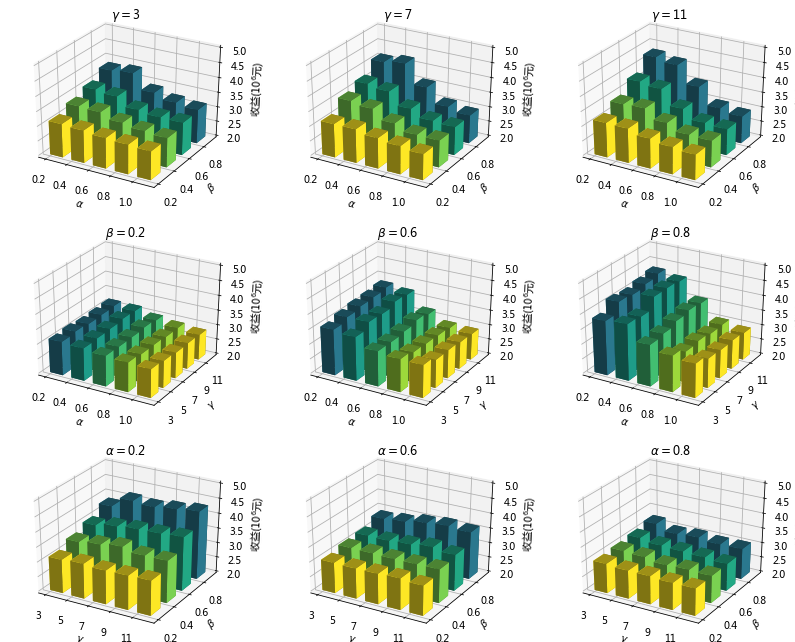

In [602]:
plt.close('all')
fig = plt.figure(figsize=(14, 11.5))
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
axCount=1

# title = radius
ra = [3, 7, 11]
xyDict={'sense':[0.2,0.4,0.6,0.8,1.0], 'learn':[0.2,0.4,0.6,0.8]}
for r in ra:
    # 1. ax 
    ax = fig.add_subplot(3,3,axCount, projection='3d')
    axCount += 1
    # 2. data
    tempData = simCountry[(abs(simCountry['radius'] - r) < 0.001)]
    # 4. title, labels
    title = r'$\gamma=$' + str(r)
    labels = [r'$\alpha$', r'$\beta$', r'收益($10^6$元)']
    plot3Dbar(ax, filteredData=tempData, xyDict=xyDict, zMinMax=[zMin, zMax], title=title, labels=labels, colorAxis='y', colorInverse=True)

# title = learn
le = [0.2, 0.6, 0.8]
xyDict={'sense':[0.2,0.4,0.6,0.8,1.0], 'radius':[3,5,7,9,11]}
for l in le:
    ax = fig.add_subplot(3,3,axCount, projection='3d')
    axCount += 1
    tempData = simCountry[(abs(simCountry['learn'] - l) < 0.001)]
    title = r'$\beta=$' + str(l)
    labels = [r'$\alpha$', r'$\gamma$', r'收益($10^6$元)']
    plot3Dbar(ax, filteredData=tempData, xyDict=xyDict, dy=1.2, zMinMax=[zMin, zMax], title=title, labels=labels, colorAxis='x', colorInverse=False)
    
se = [0.2, 0.6, 0.8]
xyDict={'radius':[3,5,7,9,11],'learn':[0.2,0.4,0.6,0.8]}
for s in se:
    ax = fig.add_subplot(3,3,axCount, projection='3d')
    axCount += 1
    tempData = simCountry[(abs(simCountry['sense'] - s) < 0.001)]
    title = r'$\alpha=$' + str(s)
    labels = [r'$\gamma$', r'$\beta$', r'收益($10^6$元)']
    plot3Dbar(ax, filteredData=tempData, xyDict=xyDict, dx=1.2, zMinMax=[zMin, zMax], title=title, labels=labels, colorAxis='y', colorInverse=True)
    
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.15)
plt.show()